### Importing necessary libraries

In [1]:
import pandas as pd

from wordcloud import WordCloud
import spacy
import matplotlib.pyplot as plt
import re
import random
from spacy.util import minibatch, compounding

In [2]:
# Dataset from https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

df_train = pd.read_csv("drugsComTrain_raw.csv", date_parser='date')
df_train

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


In [8]:
df_train.drugName.value_counts()

# 3436 unique drugs

Levonorgestrel                                   3657
Etonogestrel                                     3336
Ethinyl estradiol / norethindrone                2850
Nexplanon                                        2156
Ethinyl estradiol / norgestimate                 2117
                                                 ... 
Dazidox                                             1
Methenamine / sodium acid phosphate                 1
Dextromethorphan / phenylephrine / pyrilamine       1
Labetalol                                           1
Savaysa                                             1
Name: drugName, Length: 3436, dtype: int64

In [4]:
def process_text(review):
    processed_token = []
    for token in review.split():
        token = ''.join(e.lower() for e in token if e.isalnum())
        processed_token.append(token)
    return ' '.join(processed_token)

df_train['processed_text'] = df_train['review'].apply(lambda text: process_text(text))

In [5]:
def make_wordcloud(col):
    print('Creating wordcloud...')
    contentCorpus = col.values
    wordcloud = WordCloud(width = 3000, height = 2500, colormap="Oranges_r").generate(str(contentCorpus))
    fig = plt.figure(figsize = (10, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

Creating wordcloud...


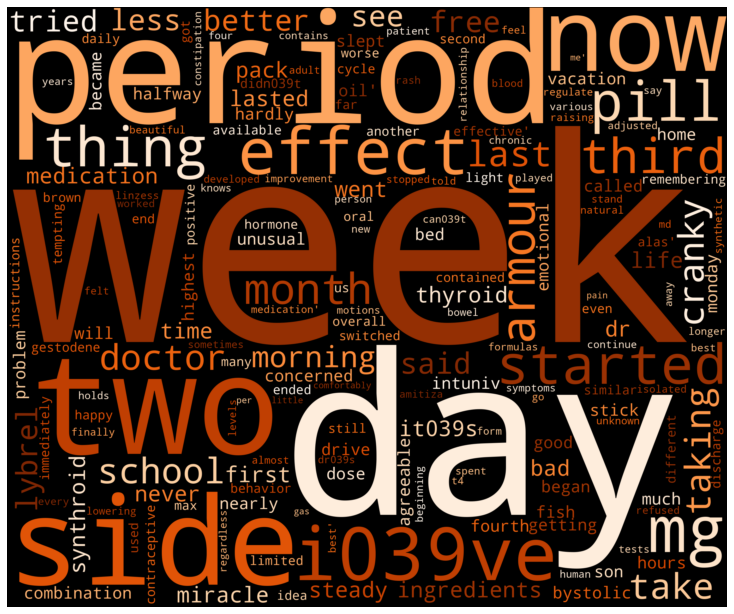

In [6]:
make_wordcloud(df_train.processed_text)

In [9]:
drugs = df_train['drugName'].value_counts().index.tolist()
drugs = [x.lower() for x in drug_list]
drugs[:10]

['levonorgestrel',
 'etonogestrel',
 'ethinyl estradiol / norethindrone',
 'nexplanon',
 'ethinyl estradiol / norgestimate',
 'ethinyl estradiol / levonorgestrel',
 'phentermine',
 'sertraline',
 'escitalopram',
 'mirena']

### Creating Training data

In [12]:
# Maximum length of training data
max_count = 0
TRAIN_DATA = []

for _, row in df_train.iterrows():
    ent_dict = {}
    if max_count < 1000:
        review = row['processed_text']
        visited = []
        entities = []
        
        for token in review.split():
            if token in drug_list:
                for i in re.finditer(token, review):
                    # Save the drug's positions once and add to the visited items.
                    if token not in visited:
                        entity = (i.span()[0], i.span()[1], 'DRUG')
                        visited.append(token)
                        entities.append(entity)
                        
        if len(entities):
            ent_dict['entities'] = entities
            train_item = (review, ent_dict)
            TRAIN_DATA.append(train_item)
            max_count += 1

### Training using Spacy

In [13]:
n_iter = 10

def train():
    nlp = spacy.blank("en")  
    print("Created blank 'en' model")
    
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    
    else:
        ner = nlp.get_pipe("ner")
        
    # Add annotations
    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])
            
    nlp.begin_training()
    for itr in range(n_iter):
        random.shuffle(TRAIN_DATA)
        losses = {}
        # Batch up the examples using spaCy's minibatch
        batches = minibatch(TRAIN_DATA, size=compounding(2.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(
                        texts,       # batch of texts
                        annotations, # batch of annotations
                        drop=0.5,    # dropout 
                        losses=losses)
            if itr%5==0:
                print("Losses", losses)
    return nlp

In [14]:
model_ner = train()

Created blank 'en' model
Losses {'ner': 179.1666510105133}
Losses {'ner': 363.22165727615356}
Losses {'ner': 439.1584244966507}
Losses {'ner': 572.7497173547745}
Losses {'ner': 700.0001217126846}
Losses {'ner': 837.3769598603249}
Losses {'ner': 929.4086793065071}
Losses {'ner': 1001.3199321627617}
Losses {'ner': 1030.9839432239532}
Losses {'ner': 1049.4311412498355}
Losses {'ner': 1077.9218415766954}
Losses {'ner': 1087.2071591848508}
Losses {'ner': 1091.8780741498922}
Losses {'ner': 1103.1517775401007}
Losses {'ner': 1107.1079770385993}
Losses {'ner': 1111.0575814314934}
Losses {'ner': 1119.0573641372994}
Losses {'ner': 1133.0566920680426}
Losses {'ner': 1137.0559511338254}
Losses {'ner': 1141.0535422756204}
Losses {'ner': 1149.1169813812894}
Losses {'ner': 1155.1060141074518}
Losses {'ner': 1163.019307556412}
Losses {'ner': 1168.956306658797}
Losses {'ner': 1173.0412153881125}
Losses {'ner': 1180.9724024554862}
Losses {'ner': 1186.949428871766}
Losses {'ner': 1190.9103320473196}
Loss

Losses {'ner': 2438.246803762507}
Losses {'ner': 2441.933756118763}
Losses {'ner': 2443.457050387047}
Losses {'ner': 2452.415247179048}
Losses {'ner': 2457.37836844394}
Losses {'ner': 2462.4730458266954}
Losses {'ner': 2465.4609918084425}
Losses {'ner': 2467.7941080158525}
Losses {'ner': 2470.238921960008}
Losses {'ner': 2475.526212381874}
Losses {'ner': 2478.2568870385376}
Losses {'ner': 2480.438825027044}
Losses {'ner': 2485.8681069232707}
Losses {'ner': 2491.596254810135}
Losses {'ner': 2494.621178824729}
Losses {'ner': 2498.385238207719}
Losses {'ner': 2502.876987687548}
Losses {'ner': 2510.1739901973106}
Losses {'ner': 2513.990426328896}
Losses {'ner': 2515.3887636266463}
Losses {'ner': 2516.5284842752576}
Losses {'ner': 2520.59164776274}
Losses {'ner': 2521.822106573929}
Losses {'ner': 2532.2544969649716}
Losses {'ner': 2537.1020745041433}
Losses {'ner': 2539.639304921318}
Losses {'ner': 2548.0483829743857}
Losses {'ner': 2549.13720982334}
Losses {'ner': 2552.327526633635}
Losses

Losses {'ner': 10.628605009671332}
Losses {'ner': 10.701234533919685}
Losses {'ner': 10.909866281153688}
Losses {'ner': 11.692050175546049}
Losses {'ner': 13.313296607529727}
Losses {'ner': 13.315623287282563}
Losses {'ner': 13.32689660434567}
Losses {'ner': 13.328979798166003}
Losses {'ner': 17.29339380854256}
Losses {'ner': 17.293803619834726}
Losses {'ner': 17.48041620820022}
Losses {'ner': 17.496367390473583}
Losses {'ner': 17.53402313037857}
Losses {'ner': 17.53443059299441}
Losses {'ner': 17.534431201188728}
Losses {'ner': 17.624163026512804}
Losses {'ner': 19.533803599212167}
Losses {'ner': 22.093946786204175}
Losses {'ner': 23.77454004483581}
Losses {'ner': 23.775133920614074}
Losses {'ner': 23.77688891652105}
Losses {'ner': 25.847524697511886}
Losses {'ner': 25.859832549460634}
Losses {'ner': 25.93626172659664}
Losses {'ner': 28.427519230606734}
Losses {'ner': 28.607336237456227}
Losses {'ner': 30.989949705457057}
Losses {'ner': 35.01694996637917}
Losses {'ner': 35.23251076842

Losses {'ner': 339.4457985299643}
Losses {'ner': 343.1104686560104}
Losses {'ner': 343.1317904693375}
Losses {'ner': 344.86056787712187}
Losses {'ner': 345.0754246124748}
Losses {'ner': 356.5646501882453}
Losses {'ner': 356.6161385445649}
Losses {'ner': 356.63683854871573}
Losses {'ner': 356.637281072155}
Losses {'ner': 356.8178838765054}
Losses {'ner': 356.83551424180473}
Losses {'ner': 358.3913622938111}
Losses {'ner': 358.9427454229515}
Losses {'ner': 364.4931920511506}
Losses {'ner': 367.52468520396417}
Losses {'ner': 371.7968105013506}
Losses {'ner': 373.9058229619027}
Losses {'ner': 375.90520222476243}
Losses {'ner': 375.93239042933897}
Losses {'ner': 381.45639069422583}
Losses {'ner': 383.67401087585523}
Losses {'ner': 385.4796780623525}
Losses {'ner': 385.9239830545611}
Losses {'ner': 386.3417183582614}
Losses {'ner': 388.8881794786028}
Losses {'ner': 388.88844328369095}
Losses {'ner': 388.9101910598259}
Losses {'ner': 388.9303051871374}
Losses {'ner': 390.90982496388443}
Losse

In [25]:
for text,_ in TRAIN_DATA[:10]:
    doc = model_ner(text)
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('skyla', 'DRUG'), ('ibuprofen', 'DRUG')]
Entities [('amoxil', 'DRUG'), ('ceftin', 'DRUG')]
Entities [('effexor', 'DRUG'), ('ativan', 'DRUG'), ('lexapro', 'DRUG'), ('zoloft', 'DRUG')]
Entities [('excedrin', 'DRUG')]
Entities [('viibryd', 'DRUG')]
Entities [('wellbutrin', 'DRUG'), ('cymbalta', 'DRUG'), ('fetzima', 'DRUG')]
Entities [('cataflam', 'DRUG')]
Entities [('metoprolol', 'DRUG'), ('hydrochlorothiazide', 'DRUG')]
Entities [('latuda', 'DRUG'), ('lexapro', 'DRUG'), ('depressrion', 'DRUG'), ('ativan', 'DRUG')]
Entities [('avelox', 'DRUG')]


In [23]:
# Saving the model to working directory
model_ner.to_disk("./")

# Loading the model
nlp2 = spacy.load("./")

### Testing on last data points (unseen)

In [26]:
test_reviews = df_train.iloc[-10:, :]['review']
for review in test_reviews:
    print(review)
    doc = nlp2(review)
    print("\nEntities", [(ent.text, ent.label_) for ent in doc.ents])
    print('--------------------------------------------------------\n')

"I was super against taking medication. I&#039;ve started dealing with anxiety (some depression) for awhile now. I got prescribed Ativan months ago, and never took it. I thought I could handle myself again but then my relationship started to fail because of my over thinking. I went back to the doctor, and decided to try it. She prescribed me .50 3 times a day. I took a full one at night after a bad panic attack, and within 30 minutes I was calm and slept through the entire night. I have only been taking a half morning and mid afternoon and full at night because it does make you feel tired. My brain is in a slight fog, but nothing crazy, I still know whats going on though :) Give it a try if you are suffering. You will know after 1."

Entities [('Ativan', 'DRUG')]
--------------------------------------------------------

"I have been off Prozac for about 4 weeks now...after starting 2 years ago for a terrible depression/sadness/menopause. Wanted to take a Holiday to see what would happe